# Applying Temporal Convolutional Network (TCN) to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz

This is notebook to explore Prophet algorithm viability to predict mass flow rates in a off-shore riser. Specifically, we are investigating liquid mass flow rate in this notebook. 


## Imports:

In [1]:
import os
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging, multivariate_data, univariate_data
from configuration import configure 
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML")
from main import model_init, model_train, model_predict
# for tcn applications
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN
import tensorflow as tf
# for data configurations
import sys
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import adjusted_rand_score
import datetime as dttm

Importing plotly failed. Interactive plots will not work.


#### Reading the data and visualization:

Our split here is to use the previous 10 periods to predict the last period. 

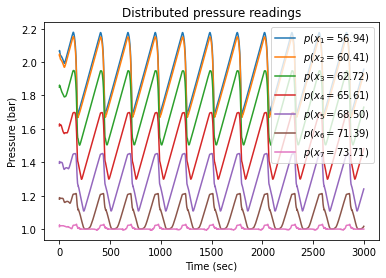

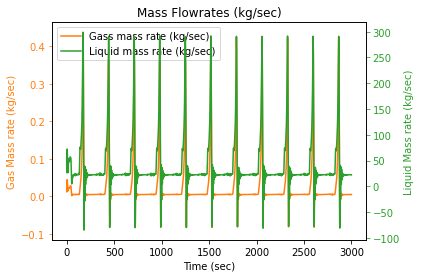

In [82]:
df,data_slugging,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)
## univariate data 
dt_liq_riser = np.array(df['liquid(kg/sec)'])
## mutlivariate data 
df_liq_riser = df.drop('liquid(kg/sec)', axis=1)
df_liq_riser = df_liq_riser.set_index('ds')
## configuration for our training purposes - 
x_mult_pst, y_mult_pst = multivariate_data(np.array(df_liq_riser), 0, 2805, 300, 5, column_index=7)
x_uni, y_uni = univariate_data(np.array(dt_liq_riser), 0, 2805, 300, 5)
## configuration for testing purposes 
x_testing_mult,  y_testing_mult = multivariate_data(np.array(df_liq_riser), 2500, 2999, 300, 5, column_index=7)
x_testing_uni, y_testing_uni = univariate_data(np.array(dt_liq_riser), 2500, 2999, 300, 5)
## for past readings
df_liq_riser = pd.concat([df_liq_riser, df['gas(kg/sec)']], axis=1)
x_mult_pstX, y_mult_pstX = multivariate_data(np.array(df_liq_riser), 0, 2805, 300, 5, column_index=8)
x_testing_multX,  y_testing_multX = multivariate_data(np.array(df_liq_riser), 2500, 2999, 300, 5, column_index=8)

#### Initialization:
We are trying to find the difference between univariate, multivairate, tuned and basic implementation of TCN. 

In [83]:
tcn_liq_basic_uni= model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,1)}, 5])
tcn_liq_basic_mult_pressure = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[{'input_shape':(300,7)}, 5])
tcn_liq_basic_mult_pressure_tuned = model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,7), 'nb_filters':128, 'kernel_size':6, 'dilations':(1, 2, 4, 8, 16, 32, 64), 'dropout_rate':0.2}, 5])
tcn_liq_basic_mult_pst= model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,8), 'nb_filters':64, 'kernel_size':3, 'dilations':(1, 2, 4, 8, 16, 32, 64), 'dropout_rate':0.2}, 5])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_44 (TCN)                 (None, 64)                136256    
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_45 (TCN)                 (None, 64)                137792    
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 325       
Total params: 138,117
Trainable params: 138,117
Non-trainable params: 0
_________________________________________________________________
Model: "sequential

#### Training:
We train our model on the training data.

In [84]:
history_uni_model = tcn_liq_basic_uni.fit(x_uni,y_uni, epochs=250, validation_split=0.8)

Epoch 1/250
4/4 [==============================] - 3s 467ms/step - loss: 68.4558 - val_loss: 2.8950
Epoch 2/250
4/4 [==============================] - 1s 351ms/step - loss: 3.0331 - val_loss: 1.6535
Epoch 3/250
4/4 [==============================] - 1s 320ms/step - loss: 1.2287 - val_loss: 0.5293
Epoch 4/250
4/4 [==============================] - 1s 303ms/step - loss: 0.6413 - val_loss: 0.7379
Epoch 5/250
4/4 [==============================] - 1s 298ms/step - loss: 0.7025 - val_loss: 0.3425
Epoch 6/250
4/4 [==============================] - 1s 308ms/step - loss: 0.3512 - val_loss: 0.3397
Epoch 7/250
4/4 [==============================] - 1s 303ms/step - loss: 0.3228 - val_loss: 0.2080
Epoch 8/250
4/4 [==============================] - 1s 297ms/step - loss: 0.1917 - val_loss: 0.1548
Epoch 9/250
4/4 [==============================] - 1s 295ms/step - loss: 0.1516 - val_loss: 0.1310
Epoch 10/250
4/4 [==============================] - 1s 300ms/step - loss: 0.1152 - val_loss: 0.0946
Epoch 11

4/4 [==============================] - 1s 299ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 84/250
4/4 [==============================] - 1s 341ms/step - loss: 0.0034 - val_loss: 0.0107
Epoch 85/250
4/4 [==============================] - 1s 316ms/step - loss: 0.0034 - val_loss: 0.0111
Epoch 86/250
4/4 [==============================] - 1s 352ms/step - loss: 0.0039 - val_loss: 0.0119
Epoch 87/250
4/4 [==============================] - 1s 316ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 88/250
4/4 [==============================] - 1s 300ms/step - loss: 0.0038 - val_loss: 0.0111
Epoch 89/250
4/4 [==============================] - 1s 363ms/step - loss: 0.0045 - val_loss: 0.0100
Epoch 90/250
4/4 [==============================] - 1s 301ms/step - loss: 0.0031 - val_loss: 0.0102
Epoch 91/250
4/4 [==============================] - 1s 305ms/step - loss: 0.0034 - val_loss: 0.0097
Epoch 92/250
4/4 [==============================] - 1s 305ms/step - loss: 0.0031 - val_loss: 0.0109
Epoch 93/250


Epoch 164/250
4/4 [==============================] - 1s 299ms/step - loss: 8.8754e-04 - val_loss: 0.0068
Epoch 165/250
4/4 [==============================] - 1s 366ms/step - loss: 8.7509e-04 - val_loss: 0.0068
Epoch 166/250
4/4 [==============================] - 1s 302ms/step - loss: 8.2474e-04 - val_loss: 0.0075
Epoch 167/250
4/4 [==============================] - 1s 303ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 168/250
4/4 [==============================] - 1s 311ms/step - loss: 0.0010 - val_loss: 0.0069
Epoch 169/250
4/4 [==============================] - 1s 311ms/step - loss: 9.1915e-04 - val_loss: 0.0067
Epoch 170/250
4/4 [==============================] - 1s 306ms/step - loss: 8.1755e-04 - val_loss: 0.0065
Epoch 171/250
4/4 [==============================] - 1s 310ms/step - loss: 9.0596e-04 - val_loss: 0.0069
Epoch 172/250
4/4 [==============================] - 1s 298ms/step - loss: 0.0011 - val_loss: 0.0072
Epoch 173/250
4/4 [==============================] - 1s 303ms/step 

4/4 [==============================] - 1s 312ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 245/250
4/4 [==============================] - 1s 310ms/step - loss: 0.0013 - val_loss: 0.0069
Epoch 246/250
4/4 [==============================] - 1s 312ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 247/250
4/4 [==============================] - 1s 308ms/step - loss: 0.0025 - val_loss: 0.0081
Epoch 248/250
4/4 [==============================] - 1s 315ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 249/250
4/4 [==============================] - 1s 313ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 250/250
4/4 [==============================] - 1s 306ms/step - loss: 0.0024 - val_loss: 0.0068


In [85]:
history_mult_model_pst = tcn_liq_basic_mult_pressure.fit(x_mult_pst,y_mult_pst, epochs=250, validation_split=0.8)

Epoch 1/250
4/4 [==============================] - 3s 428ms/step - loss: 262.2576 - val_loss: 4.9952
Epoch 2/250
4/4 [==============================] - 1s 297ms/step - loss: 5.2129 - val_loss: 4.1802
Epoch 3/250
4/4 [==============================] - 1s 294ms/step - loss: 3.5236 - val_loss: 0.6626
Epoch 4/250
4/4 [==============================] - 1s 299ms/step - loss: 0.4879 - val_loss: 0.3523
Epoch 5/250
4/4 [==============================] - 1s 307ms/step - loss: 0.3368 - val_loss: 0.1676
Epoch 6/250
4/4 [==============================] - 1s 315ms/step - loss: 0.1478 - val_loss: 0.1703
Epoch 7/250
4/4 [==============================] - 1s 322ms/step - loss: 0.1583 - val_loss: 0.1163
Epoch 8/250
4/4 [==============================] - 1s 319ms/step - loss: 0.0984 - val_loss: 0.0641
Epoch 9/250
4/4 [==============================] - 1s 322ms/step - loss: 0.0729 - val_loss: 0.0603
Epoch 10/250
4/4 [==============================] - 1s 320ms/step - loss: 0.0506 - val_loss: 0.0486
Epoch 1

Epoch 83/250
4/4 [==============================] - 1s 322ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 84/250
4/4 [==============================] - 1s 323ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 85/250
4/4 [==============================] - 1s 331ms/step - loss: 0.0132 - val_loss: 0.0100
Epoch 86/250
4/4 [==============================] - 1s 401ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 87/250
4/4 [==============================] - 1s 333ms/step - loss: 0.0101 - val_loss: 0.0150
Epoch 88/250
4/4 [==============================] - 1s 338ms/step - loss: 0.0148 - val_loss: 0.0129
Epoch 89/250
4/4 [==============================] - 1s 331ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 90/250
4/4 [==============================] - 1s 334ms/step - loss: 0.0153 - val_loss: 0.0127
Epoch 91/250
4/4 [==============================] - 1s 317ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 92/250
4/4 [==============================] - 1s 318ms/step - loss: 0.0124 - val_loss: 0.0095


4/4 [==============================] - 1s 333ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 165/250
4/4 [==============================] - 1s 317ms/step - loss: 0.0146 - val_loss: 0.0106
Epoch 166/250
4/4 [==============================] - 1s 318ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 167/250
4/4 [==============================] - 1s 316ms/step - loss: 0.0125 - val_loss: 0.0149
Epoch 168/250
4/4 [==============================] - 1s 315ms/step - loss: 0.0167 - val_loss: 0.0123
Epoch 169/250
4/4 [==============================] - 1s 332ms/step - loss: 0.0129 - val_loss: 0.0100
Epoch 170/250
4/4 [==============================] - 1s 335ms/step - loss: 0.0130 - val_loss: 0.0095
Epoch 171/250
4/4 [==============================] - 1s 337ms/step - loss: 0.0141 - val_loss: 0.0091
Epoch 172/250
4/4 [==============================] - 1s 324ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 173/250
4/4 [==============================] - 1s 329ms/step - loss: 0.0130 - val_loss: 0.0098
Epoc

4/4 [==============================] - 1s 322ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 246/250
4/4 [==============================] - 1s 319ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 247/250
4/4 [==============================] - 1s 326ms/step - loss: 0.0082 - val_loss: 0.0113
Epoch 248/250
4/4 [==============================] - 1s 329ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 249/250
4/4 [==============================] - 1s 327ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 250/250
4/4 [==============================] - 1s 326ms/step - loss: 0.0128 - val_loss: 0.0090


In [86]:
history_mult_model_pst_tuned = tcn_liq_basic_mult_pressure_tuned.fit(x_mult_pst,y_mult_pst, epochs=250, validation_split=0.8)

Epoch 1/250
4/4 [==============================] - 8s 2s/step - loss: 510.0449 - val_loss: 2.8482
Epoch 2/250
4/4 [==============================] - 5s 1s/step - loss: 10.1971 - val_loss: 4.0226
Epoch 3/250
4/4 [==============================] - 6s 2s/step - loss: 6.0048 - val_loss: 0.5289
Epoch 4/250
4/4 [==============================] - 6s 2s/step - loss: 2.9489 - val_loss: 0.3197
Epoch 5/250
4/4 [==============================] - 6s 2s/step - loss: 2.1698 - val_loss: 0.1350
Epoch 6/250
4/4 [==============================] - 6s 2s/step - loss: 1.2505 - val_loss: 0.2170
Epoch 7/250
4/4 [==============================] - 6s 2s/step - loss: 0.7365 - val_loss: 0.1787
Epoch 8/250
4/4 [==============================] - 6s 2s/step - loss: 0.7503 - val_loss: 0.1323
Epoch 9/250
4/4 [==============================] - 6s 2s/step - loss: 0.5497 - val_loss: 0.0966
Epoch 10/250
4/4 [==============================] - 6s 2s/step - loss: 0.4411 - val_loss: 0.0772
Epoch 11/250
4/4 [==================

4/4 [==============================] - 6s 2s/step - loss: 0.0682 - val_loss: 0.0309
Epoch 86/250
4/4 [==============================] - 6s 2s/step - loss: 0.0665 - val_loss: 0.0318
Epoch 87/250
4/4 [==============================] - 6s 2s/step - loss: 0.0567 - val_loss: 0.0320
Epoch 88/250
4/4 [==============================] - 6s 2s/step - loss: 0.0573 - val_loss: 0.0304
Epoch 89/250
4/4 [==============================] - 6s 2s/step - loss: 0.0590 - val_loss: 0.0306
Epoch 90/250
4/4 [==============================] - 6s 2s/step - loss: 0.0664 - val_loss: 0.0309
Epoch 91/250
4/4 [==============================] - 6s 2s/step - loss: 0.0567 - val_loss: 0.0315
Epoch 92/250
4/4 [==============================] - 6s 2s/step - loss: 0.0698 - val_loss: 0.0264
Epoch 93/250
4/4 [==============================] - 6s 2s/step - loss: 0.0568 - val_loss: 0.0260
Epoch 94/250
4/4 [==============================] - 6s 2s/step - loss: 0.0564 - val_loss: 0.0310
Epoch 95/250
4/4 [=========================

Epoch 169/250
4/4 [==============================] - 6s 2s/step - loss: 0.0336 - val_loss: 0.0256
Epoch 170/250
4/4 [==============================] - 6s 2s/step - loss: 0.0396 - val_loss: 0.0257
Epoch 171/250
4/4 [==============================] - 6s 2s/step - loss: 0.0384 - val_loss: 0.0252
Epoch 172/250
4/4 [==============================] - 6s 2s/step - loss: 0.0381 - val_loss: 0.0257
Epoch 173/250
4/4 [==============================] - 6s 2s/step - loss: 0.0358 - val_loss: 0.0260
Epoch 174/250
4/4 [==============================] - 6s 2s/step - loss: 0.0349 - val_loss: 0.0256
Epoch 175/250
4/4 [==============================] - 6s 2s/step - loss: 0.0353 - val_loss: 0.0255
Epoch 176/250
4/4 [==============================] - 6s 2s/step - loss: 0.0389 - val_loss: 0.0263
Epoch 177/250
4/4 [==============================] - 6s 2s/step - loss: 0.0357 - val_loss: 0.0262
Epoch 178/250
4/4 [==============================] - 6s 2s/step - loss: 0.0344 - val_loss: 0.0259
Epoch 179/250
4/4 [=

In [87]:
history_mult_model_pst = tcn_liq_basic_mult_pst.fit(x_mult_pstX,y_mult_pstX, epochs=250, validation_split=0.05)

Epoch 1/250
15/15 [==============================] - 12s 297ms/step - loss: 350.2968 - val_loss: 0.3501
Epoch 2/250
15/15 [==============================] - 4s 291ms/step - loss: 5.6480 - val_loss: 0.4879
Epoch 3/250
15/15 [==============================] - 5s 353ms/step - loss: 2.6301 - val_loss: 0.2449
Epoch 4/250
15/15 [==============================] - 6s 425ms/step - loss: 1.7888 - val_loss: 0.1454
Epoch 5/250
15/15 [==============================] - 6s 397ms/step - loss: 1.5612 - val_loss: 0.1255
Epoch 6/250
15/15 [==============================] - 5s 311ms/step - loss: 1.2256 - val_loss: 0.1215
Epoch 7/250
15/15 [==============================] - 5s 360ms/step - loss: 1.1106 - val_loss: 0.0999
Epoch 8/250
15/15 [==============================] - 5s 318ms/step - loss: 0.9584 - val_loss: 0.0732
Epoch 9/250
15/15 [==============================] - 6s 410ms/step - loss: 0.8154 - val_loss: 0.0622
Epoch 10/250
15/15 [==============================] - 4s 293ms/step - loss: 0.7938 - val

15/15 [==============================] - 7s 493ms/step - loss: 0.0531 - val_loss: 0.0035
Epoch 82/250
15/15 [==============================] - 6s 390ms/step - loss: 0.0521 - val_loss: 0.0033
Epoch 83/250
15/15 [==============================] - 6s 368ms/step - loss: 0.0591 - val_loss: 0.0030
Epoch 84/250
15/15 [==============================] - 5s 326ms/step - loss: 0.0500 - val_loss: 0.0039
Epoch 85/250
15/15 [==============================] - 5s 357ms/step - loss: 0.0520 - val_loss: 0.0036
Epoch 86/250
15/15 [==============================] - 5s 346ms/step - loss: 0.0484 - val_loss: 0.0048
Epoch 87/250
15/15 [==============================] - 7s 465ms/step - loss: 0.0490 - val_loss: 0.0034
Epoch 88/250
15/15 [==============================] - 6s 396ms/step - loss: 0.0522 - val_loss: 0.0026
Epoch 89/250
15/15 [==============================] - 5s 320ms/step - loss: 0.0504 - val_loss: 0.0030
Epoch 90/250
15/15 [==============================] - 9s 595ms/step - loss: 0.0436 - val_loss: 

Epoch 160/250
15/15 [==============================] - 4s 249ms/step - loss: 0.0153 - val_loss: 6.0613e-04
Epoch 161/250
15/15 [==============================] - 4s 243ms/step - loss: 0.0159 - val_loss: 8.6628e-04
Epoch 162/250
15/15 [==============================] - 4s 257ms/step - loss: 0.0149 - val_loss: 8.6169e-04
Epoch 163/250
15/15 [==============================] - 4s 253ms/step - loss: 0.0162 - val_loss: 8.0537e-04
Epoch 164/250
15/15 [==============================] - 4s 250ms/step - loss: 0.0138 - val_loss: 0.0010
Epoch 165/250
15/15 [==============================] - 4s 245ms/step - loss: 0.0196 - val_loss: 9.5682e-04
Epoch 166/250
15/15 [==============================] - 4s 249ms/step - loss: 0.0139 - val_loss: 4.4356e-04
Epoch 167/250
15/15 [==============================] - 4s 256ms/step - loss: 0.0136 - val_loss: 5.7617e-04
Epoch 168/250
15/15 [==============================] - 4s 266ms/step - loss: 0.0130 - val_loss: 6.1277e-04
Epoch 169/250
15/15 [====================

15/15 [==============================] - 4s 261ms/step - loss: 0.0080 - val_loss: 6.0889e-04
Epoch 238/250
15/15 [==============================] - 4s 256ms/step - loss: 0.0088 - val_loss: 3.4474e-04
Epoch 239/250
15/15 [==============================] - 4s 262ms/step - loss: 0.0081 - val_loss: 3.9824e-04
Epoch 240/250
15/15 [==============================] - 4s 257ms/step - loss: 0.0076 - val_loss: 3.5921e-04
Epoch 241/250
15/15 [==============================] - 4s 250ms/step - loss: 0.0074 - val_loss: 5.7408e-04
Epoch 242/250
15/15 [==============================] - 4s 250ms/step - loss: 0.0078 - val_loss: 2.6320e-04
Epoch 243/250
15/15 [==============================] - 4s 255ms/step - loss: 0.0071 - val_loss: 6.7263e-04
Epoch 244/250
15/15 [==============================] - 4s 249ms/step - loss: 0.0075 - val_loss: 3.0213e-04
Epoch 245/250
15/15 [==============================] - 4s 244ms/step - loss: 0.0070 - val_loss: 4.3846e-04
Epoch 246/250
15/15 [==============================

#### Testing and visualization:
Here we use the testing data to find TCN accuracy. 

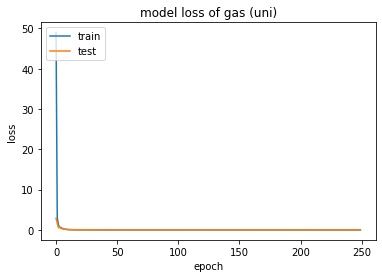

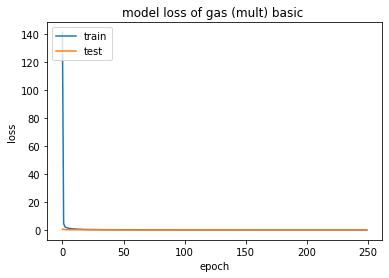

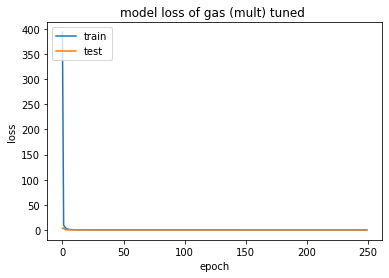

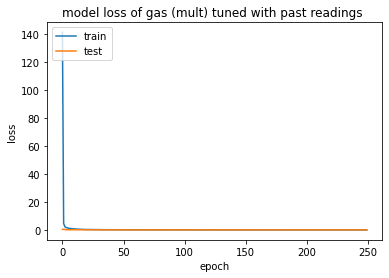

In [89]:
## Liquid
# # summarize history for loss
plt.plot(history_uni_model.history['loss'])
plt.plot(history_uni_model.history['val_loss'])
plt.title('model loss of gas (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_mult_model_pst.history['loss'])
plt.plot(history_mult_model_pst.history['val_loss'])
plt.title('model loss of gas (mult) basic ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_mult_model_pst_tuned.history['loss'])
plt.plot(history_mult_model_pst_tuned.history['val_loss'])
plt.title('model loss of gas (mult) tuned ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_mult_model_pst.history['loss'])
plt.plot(history_mult_model_pst.history['val_loss'])
plt.title('model loss of gas (mult) tuned with past readings ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
## liquid testing data set visualization
### univariate 
real_liq_uni = y_testing_uni.flatten()
pred_liq_uni = tcn_liq_basic_uni.predict(x_testing_uni).flatten()
df_plot_liq_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_uni, real_liq_uni]))))
df_plot_liq_uni['ds']=range(2800,2995)
# ### multivariate 
real_liq_mult = y_testing_mult.flatten()
pred_liq_mult = tcn_liq_basic_mult_pressure.predict(x_testing_mult).flatten()
df_plot_liq_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult, real_liq_mult]))))
df_plot_liq_mult['ds']=range(2800,3000)
# ### multivariate 
real_liq_mult_pst = y_testing_mult.flatten()
pred_liq_mult_pst = tcn_liq_basic_mult_pressure_tuned.predict(x_testing_mult).flatten()
df_plot_liq_mult_pst=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult_pst, real_liq_mult_pst]))))
df_plot_liq_mult_pst['ds']=range(2800,3000)
# # ### multivariate 
real_liq_mult_pstX = y_testing_multX.flatten()
pred_liq_mult_pstX = tcn_liq_basic_mult_pst.predict(x_testing_multX).flatten()
df_plot_liq_mult_pstX=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult_pstX, real_liq_mult_pstX]))))
df_plot_liq_mult_pstX['ds']=range(2800,3000)

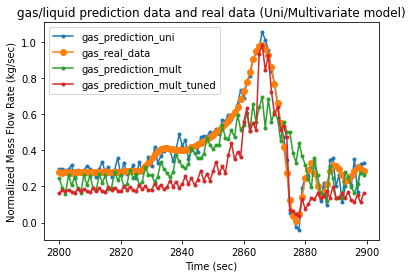

In [94]:
start = 0
end = 100
fig,ax = plt.subplots()
ax.set_title('gas/liquid prediction data and real data (Uni/Multivariate model)')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['prediction'].iloc[start:end], marker=".", label='gas_prediction_uni')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['real'].iloc[start:end], marker="o", label='gas_real_data')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Normalized Mass Flow Rate (kg/sec)')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['prediction'].iloc[start:end], marker=".", label='gas_prediction_mult')
# ax.plot(df_plot_liq_mult_pst['ds'].iloc[start:end], df_plot_liq_mult_pst['prediction'].iloc[start:end], marker=".", label='gas_prediction_mult_tuned')
ax.plot(df_plot_liq_mult_pstX['ds'].iloc[start:end], df_plot_liq_mult_pstX['prediction'].iloc[start:end], marker=".", label='gas_prediction_mult_tuned')
ax.legend()